## Q-learning numpy

Our agent needs to cross a lake, represented by a square divided with a 4x4 grid. At every step he needs to take an action, he can go up, down, left or right. If it's not possible to go to the chosen direction our agent will simply not move.

Each grid element can be frozen, in that case our agent will be able to move, it can he a hole, in that case the episodes end and we don't get the reward or it can be the final state, the goal. In that case the agent will receive a positive reward.

We want to use q-learning to solve this problem.

In [6]:
%matplotlib inline
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

# Meta parameters for the RL agent
alpha = 0.1
gamma = 0.99
epsilon = 0.5
epsilon_decay = 0.999
verbose = False

# Define types of algorithms
EPSILON_GREEDY = "epsilon_greedy"
SOFTMAX = "softmax"
GREEDY = "greedy"

# Choose methods for learning and exploration
rl_algorithm = 'QLEARNING'
explore_method = EPSILON_GREEDY

In [7]:
def softmax(x):
    """
    Compute softmax values. 
    Returns a vector with.
    """
    exp_x = np.exp(x - np.max(x))
    return exp_x / exp_x.sum()


# Act with softmax
def take_action_using_softmax(s, q):
    prob_a = softmax(q[s, :])
    cumsum_a = np.cumsum(prob_a)
    return np.where(np.random.rand() < cumsum_a)[0][0]


# Act with epsilon greedy
def take_action_using_epsilon_greedy(s, q):
    a = np.argmax(q[s, :])
    if np.random.rand() < epsilon:
        a = np.random.randint(q.shape[1])
    return a


def q_learning_update(q, s, a, r, s_prime):
    # TD Update 
    best_next_action = np.argmax(q[s_prime])     
    td_target = r + gamma * q[s_prime][best_next_action] 
    td_delta = td_target - q[s][a] 
    return q[s][a] + alpha * td_delta 

# Evaluate a policy on n runs
def evaluate_policy(q, env, n, h, explore_type):
    success_rate = 0.0
    mean_return = 0.0

    for i in range(n):
        discounted_return = 0.0
        s = env.reset()

        for step in range(h):
            if explore_type == GREEDY:
                s, r, done, info = env.step(np.argmax(q[s, :]))
            elif explore_type == EPSILON_GREEDY:
                s, r, done, info = env.step(
                    take_action_using_epsilon_greedy(s, q))
            elif explore_type == SOFTMAX:
                s, r, done, info = env.step(take_action_using_softmax(s, q))
            else:
                raise ValueError(
                    "Wrong Explore Method in evaluation:".format(explore_type))

            discounted_return += np.power(gamma, step) * r

            if done:
                success_rate += float(r) / n
                mean_return += float(discounted_return) / n
                break

    return success_rate, mean_return

In [8]:
# Choose environment
env_name = 'FrozenLake-v0'

# Create Environment
env = gym.make(env_name)

# Get State-Action space size
n_a = env.action_space.n
n_s = env.observation_space.n

# Experimental setup
n_episode = 3000
print("n_episode ", n_episode)
max_horizon = 100
eval_steps = 10

# Monitoring performance
window = deque(maxlen=100)

greedy_success_rate_monitor = np.zeros([n_episode, 1])
greedy_discounted_return_monitor = np.zeros([n_episode, 1])

behaviour_success_rate_monitor = np.zeros([n_episode, 1])
behaviour_discounted_return_monitor = np.zeros([n_episode, 1])

# Init Q-table
q_table = np.zeros([n_s, n_a])

env.reset()

n_episode  3000


0

  (Down)
SFFF
FHFH
FFFH
HFFG


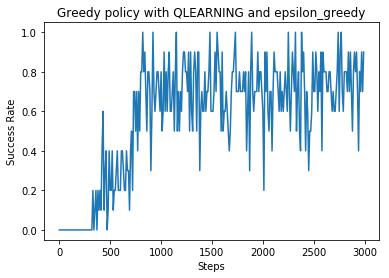

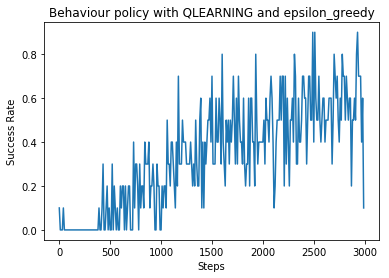

  (Down)
SFFF
FHFH
FFFH
HFFG
Episode: 1	 Num_Steps:    0	Total_Return:  0.84	Final_Reward: 0
LEFT
UP
LEFT
LEFT
LEFT
LEFT
LEFT
LEFT
UP
DOWN
LEFT
LEFT
LEFT
RIGHT
DOWN
LEFT


In [9]:
verbose = False
# Train for n_episode

for i_episode in range(n_episode):

    # Reset the expisode's cumulative reward
    total_return = 0.0

    # Start fresh with a new episode state
    s = env.reset()

    # Select the first action in this episode

    a = take_action_using_epsilon_greedy(s, q_table)

    for i_step in range(max_horizon):

        # Take action and receive the enviroment's feedback
        s_prime, r, done, info = env.step(a)

        total_return += np.power(gamma, i_step) * r

        # Select an action
        if explore_method == SOFTMAX:
            a_prime = take_action_using_softmax(s_prime, q_table)
        elif explore_method == EPSILON_GREEDY:
            a_prime = take_action_using_epsilon_greedy(s_prime, q_table)
        else:
            raise ValueError("Wrong Explore Method:".format(explore_method))

        # Update a Q value table
        q_table[s, a] = q_learning_update(q_table, s, a, r, s_prime)


        # Transition to new state
        s = s_prime
        a = a_prime

        if done:
            window.append(r)
            last_100 = window.count(1)

            greedy_success_rate_monitor[i_episode - 1, 0], greedy_discounted_return_monitor[
                i_episode - 1, 0] = evaluate_policy(q_table, env, eval_steps, max_horizon, GREEDY)
            behaviour_success_rate_monitor[i_episode - 1, 0], behaviour_discounted_return_monitor[
                i_episode - 1, 0] = evaluate_policy(q_table, env, eval_steps, max_horizon, explore_method)
            if verbose:
                print(
                    "Episode: {0}\t Num_Steps: {1:>4}\tTotal_Return: {2:>5.2f}\tFinal_Reward: {3}\tEpsilon: {4:.3f}\tSuccess Rate: {5:.3f}\tLast_100: {6}".format(
                        i_episode, i_step, total_return, r, epsilon, greedy_success_rate_monitor[i_episode - 1, 0],
                        last_100))

            break

    # Schedule for epsilon
    epsilon = epsilon * epsilon_decay


env.render()

plt.figure(0)
plt.plot(range(0, n_episode, 10), greedy_success_rate_monitor[0::10, 0])
plt.title("Greedy policy with {0} and {1}".format(rl_algorithm, explore_method))
plt.xlabel("Steps")
plt.ylabel("Success Rate")

plt.figure(1)
plt.plot(range(0, n_episode, 10), behaviour_success_rate_monitor[0::10, 0])
plt.title("Behaviour policy with {0} and {1}".format(rl_algorithm, explore_method))
plt.xlabel("Steps")
plt.ylabel("Success Rate")
plt.show()

# Show an episod

for i_step in range(max_horizon):
    env.render()
    a = np.argmax(q_table[s, :])
    s, r, done, info = env.step(a)
    total_return += np.power(gamma, i_step) * r

    if done:
        print("Episode: {0}\t Num_Steps: {1:>4}\tTotal_Return: {2:>5.2f}\tFinal_Reward: {3}".format(1, i_step,
                                                                                                    total_return,
                                                                                                    r))
        break

# Show Policy

for s in range(n_s):
    actions = ['LEFT', 'DOWN', 'RIGHT', 'UP']
    print(actions[np.argmax(q_table[s, :])])